In [701]:
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

In [702]:
# boston_df = pd.read_csv('./data/boston_train.csv')
# boston_df.drop('ID', axis=1, inplace=True)


# y = pd.DataFrame(boston_df['medv'], columns=['medv'])
# X = boston_df.drop('medv', axis=1)
scaler = StandardScaler()

boston_df = pd.read_csv('./data/housing.csv', header=None, delimiter=r"\s+", names= ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])
y = pd.DataFrame(boston_df['MEDV'], columns=['MEDV'])
X = boston_df.drop('MEDV', axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [703]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### PREPROCESSING

In [704]:
class BostonDataset(Dataset):
    def __init__(self, X, y, to_device, scaler=StandardScaler):
        self.X = torch.tensor(X, device=to_device)
        self.y = torch.tensor(y, device=to_device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()

In [705]:
def load_data(dataset, batch_size=8, train_size=0.6, test_size=0.2, val_size=0.2):
    
    dataset_len = len(dataset)
    
  
    
    train_idx = int(train_size * dataset_len)
    test_idx =int(test_size * dataset_len)
    val_idx = int(val_size * dataset_len)
    
    print(test_idx)
    print(val_idx)
    
    print(f" length : {train_idx}")
    train_set = Subset(dataset, np.arange(0, train_idx))
    test_set = Subset(dataset, np.arange(train_idx, train_idx + test_idx))
    val_set = Subset(dataset, np.arange(train_idx + test_idx, train_idx + test_idx + val_idx))
    
    
    train_dataloader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
    
    return {
        'train': train_dataloader,
        'test': val_dataloader,
        'val': test_dataloader,
        'dataset': dataset
    }

In [706]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.losses = {}
        self._epoch_loss = []
        self.accuracys = {}
        self.iterations = 0
        
        self.fc1 = nn.Linear(13, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = F.dropout(output, p=0.1)
        output = self.fc3(output)
    
        return output
    
    def fit(self, optimizer, loss_criterion, train_dataloader):
        self.train()
        
        self.iterations += 1

        for batch in train_dataloader:
            X, y = batch
            y = torch.reshape(y, (y.shape[0], 1))
                
            outputs = self.forward(X)
            loss = loss_criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            self._epoch_loss.append(loss.item())
                
        self.losses[self.iterations] = np.mean(self._epoch_loss)
        self._epoch_loss = []
   
    def validate(self, val_dataloader, loss_criterium):
        self.eval()
        
        with torch.no_grad():
            batch_losses = []
            
            for batch in val_dataloader:
                X, y = batch
                y = torch.reshape(y, (y.shape[0], 1))
                outputs = self.forward(X)
                
                loss = loss_criterium(outputs, y)
                batch_losses.append(loss)
                 
            accuracy = np.mean(batch_losses)
            self.accuracys[self.iterations] = accuracy
        return accuracy
        
    def predict(self, test_dataloader):
        self.eval()
        
        with torch.no_grad():
            predictions = []
            for X, _ in test_dataloader:
                output = self.forward(X)
                predictions.extend(output)
                
        predictions = np.stack(predictions)
                
        return predictions
        
 
        
    

In [707]:
def train_and_save(train_dataloader, val_dataloader, n_epochs, loss_criterion, opt, learning_rate, model_path=None, load_model=False):
    if load_model:
        model = torch.load(model_path)
    else:
        model = FNN()
    
    optimizer = opt(model.parameters(), lr=learning_rate)
    loss_criterion = loss_criterion()
    
    best_epoch = None
    best_accuracy = np.inf
    
    improvement = None


    for epoch in range(n_epochs): 
        model.fit(optimizer=optimizer, loss_criterion=loss_criterion, train_dataloader=train_dataloader)
        accuracy = model.validate(val_dataloader=val_dataloader, loss_criterium=loss_criterion)
        print(f"Epoch[{epoch+1}/{n_epochs}]: Iteration: {model.iterations}, Training loss: {model.losses[model.iterations]}, Validation loss: {model.accuracys[model.iterations]}")
    
        if not best_epoch:
            best_epoch = epoch
            torch.save(model.state_dict(), './best_regression_model.pth')
            continue
        
        if best_accuracy < accuracy:
            improvement = 0
            
    
        if best_accuracy > accuracy:
            best_epoch = epoch
            best_accuracy = accuracy
            torch.save(model.state_dict(), './best_regression_model.pth')
            improvement = 1
        else:
            improvement += 1
            
        if improvement == 3:
            print(f"Stopped at : {epoch}")
            break
            
    print(best_epoch)
    return model
 
    


In [708]:
boston_set = BostonDataset(X, y, device)

dataloaders = load_data(boston_set, batch_size=8, train_size=0.8, test_size=0.1, val_size=0.1)

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']



loss_criterion = nn.MSELoss
optimizer = torch.optim.Adam
learning_rate = 0.0001
n_epochs = 30

model = train_and_save(train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader, 
                       n_epochs=n_epochs,
                       loss_criterion=loss_criterion,
                       opt=optimizer,
                       learning_rate=learning_rate)


50
50
 length : 404
Epoch[1/30]: Iteration: 1, Training loss: 1.0314537054475617, Validation loss: 0.850629985332489
Epoch[2/30]: Iteration: 2, Training loss: 0.9675119858162076, Validation loss: 0.8023309707641602
Epoch[3/30]: Iteration: 3, Training loss: 0.9123640577582752, Validation loss: 0.7393152117729187
Epoch[4/30]: Iteration: 4, Training loss: 0.8815764096729896, Validation loss: 0.7614174485206604
Epoch[5/30]: Iteration: 5, Training loss: 0.8175021465502533, Validation loss: 0.6097498536109924
Epoch[6/30]: Iteration: 6, Training loss: 0.7774317883977703, Validation loss: 0.6260778307914734
Epoch[7/30]: Iteration: 7, Training loss: 0.7217997097793747, Validation loss: 0.5307080745697021
Epoch[8/30]: Iteration: 8, Training loss: 0.6980109607764319, Validation loss: 0.44454827904701233
Epoch[9/30]: Iteration: 9, Training loss: 0.6125612621213875, Validation loss: 0.4473811089992523
Epoch[10/30]: Iteration: 10, Training loss: 0.6026729403757581, Validation loss: 0.488413602113723

In [709]:
best_model = FNN()
best_model.load_state_dict(torch.load('best_regression_model.pth'))

<All keys matched successfully>

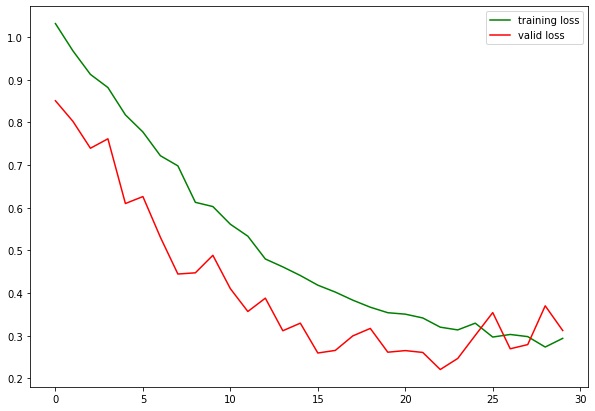

In [710]:
from matplotlib import pyplot as plt


plt.figure(figsize = (10,7))
plt.plot([i for i in range(len(model.losses.values()))], list(model.losses.values()), c = 'green', label = 'training loss')
plt.plot([i for i in range(len(model.accuracys.values()))], list(model.accuracys.values()), c = 'red', label = 'valid loss')
plt.legend()
plt.show()

In [711]:
test_dataloader = dataloaders['test']

y_pred = best_model.predict(test_dataloader=test_dataloader)
y_true = [y for _, y_batch in test_dataloader for y in y_batch]


c:\Github\applied-ai\venv\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Github\applied-ai\venv\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


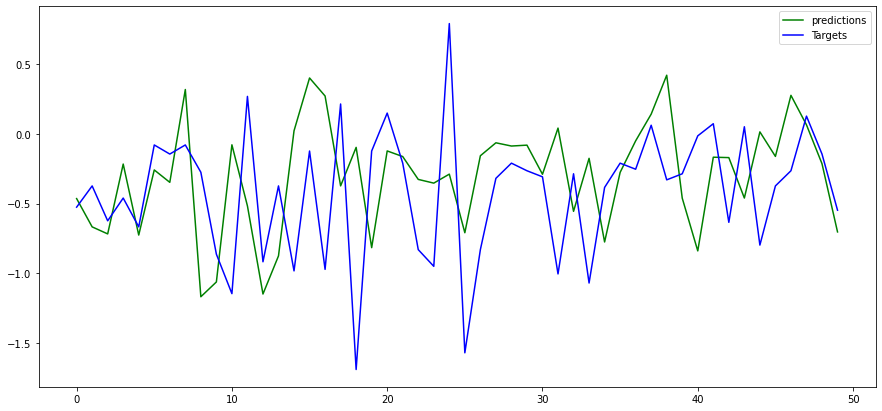

In [712]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot([i for i in range(len(y_pred))], y_pred, color="green", label="predictions")
plt.plot([i for i in range(len(y_true))], y_true, color='blue', label="Targets")

plt.legend()
plt.show()

In [713]:
from sklearn.metrics import mean_squared_error as mse

mse_score = mse(y_true, y_pred)

print(f"mse score: {mse_score}")

mse score: 0.35326315901764593


c:\Github\applied-ai\venv\lib\site-packages\sklearn\utils\validation.py:746: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = np.asarray(array, order=order, dtype=dtype)
c:\Github\applied-ai\venv\lib\site-packages\sklearn\utils\validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
c:\Github\applied-